# Evidence of A Dark Matter Halo in M33 Galaxy

### Introduction

This project is part of the AST222 course at the University of Toronto.
In this problem, we will conduct a rudimentary test for the presence of dark matter in the nearby Triangulum Galaxy (M33).

### Part A: Rotational Velocity in A Dark Matter Halo

For a dark matter halo with a spherical density distribution modeled by
$$
\rho_\mathrm{halo}(r) = \frac{V_H^2}{4 \pi G \left(r^2 + a_\mathrm{H}^2\right)},
$$

where $V_\mathrm{H}$ and $a_\mathrm{H}$ are parameters of the model, the speed of a body in a circular orbit at radius $r$ is given by

$$
V^2_\mathrm{halo}(r) = V_\mathrm{H}^2 \left[ 1 - \frac{a_\mathrm{H}}{r} \arctan \left( \frac{r}{a_\mathrm{H}} \right) \right].
$$

### Part B: A Quick Look at The Data

First, we start by reading in the provided data file (`M33_velocity_curve.csv`) and examining the contents. The file includes rotational velocity measurements derived from observations of H$\alpha$ and HI (21cm) emission from neutral hydrogen in the Triangulum Galaxy ("M33"). There are three columns: radius from the center of M33 ("R") in kpc, the measured rotational velocity ("V") in km/s, and the uncertainty in each measured rotational velocity ("sigmaV") in km/s.

Next, we will make a scatter plot of the measured rotational velocities versus radius, including errorbars (from "sigmaV") and appropriate axis labels.

In [1]:
# Import dependencies
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

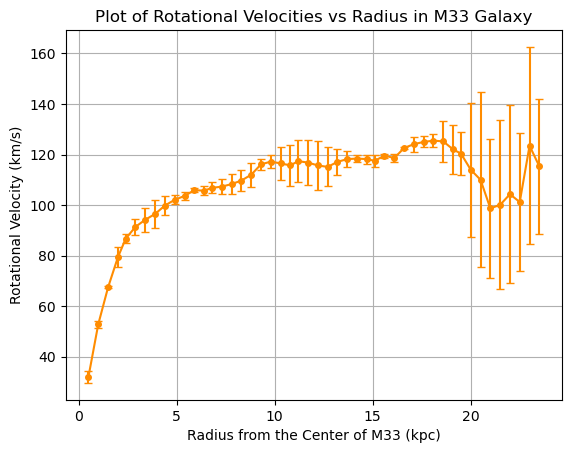

In [2]:
# load "M33_velocity_curve.csv" using `numpy.loadtxt` or `pandas.read_csv` and plot it here
import pandas as pd
data = pd.read_csv("M33_velocity_curve.csv")
R = data["R"]
V = data["V"]
sigmaV = data["sigmaV"]

fig = plt.figure()
plt.errorbar(R, V, yerr = sigmaV, marker = 'o', markersize = 4, capsize = 3, color = 'darkorange') 
plt.title('Plot of Rotational Velocities vs Radius in M33 Galaxy')
plt.xlabel('Radius from the Center of M33 (kpc)')
plt.ylabel('Rotational Velocity (km/s)')
plt.grid(True)
plt.savefig('M33.jpg')

### Part C: Fitting The Data

Deriving gravitational potentials and rotational velocities in "flattened" (i.e., not spherically symmetric) mass distribution, like the disk of a spiral galaxy, can be difficult. Often, we adopt functional forms that are easy to work with and are consistent with the data, rather than deriving functions from physical laws.

To model the disk of M33, we use the Kuzmin model of a "razor-thin disk".
The Kuzmin gravitational potential is given by

$$
\Phi_\mathrm{disk}(r, z) = -\frac{G M_\mathrm{D}}{\sqrt{r^2 + (|z| + a_\mathrm{D})^2}},
$$

where $z$ the height above the disk, $M_\mathrm{D}$ the mass of the disk, and $a_\mathrm{D}$ is a free parameter of the model.

The rotational velocity of a body in the plane of a Kuzmin disk ($z = 0$) is given by:

$$
V^2_\mathrm{disk}(r) = \frac{G M_\mathrm{D} r^2}{(r^2 + a_\mathrm{D}^2)^{3/2}}.
$$

Note that, in contrast to the halo model above, $V_\mathrm{disk}(r) \rightarrow 0$ as $r \rightarrow \infty$.

Let's try to fit the observated rotational velocity data from M33 using this model of $V_\mathrm{disk}(r)$.
(The stellar bulge doesn't contribute very much in M33 and can be neglected.)
The `scipy.optimize.curve_fit` routine is a good choice for this; make sure to include the data uncertainties, using the `sigma` keyword argument.

First, fit the data using **only** the Kuzmin thin disk model above.
The fit should include two free parameters: $a_\mathrm{D}$ and $M_\mathrm{D}$.

Second, fit the data including both a contribution from a thin stellar disk **and** a dark matter halo modeled in part A.
The fit should include four free parameters: $a_\mathrm{D}$, $M_\mathrm{D}$, $a_\mathrm{H}$, and $V_H$.
(Be mindful about how we combine the two contributions; note that $V_\mathrm{tot}(r) \neq V_\mathrm{disk}(r) + V_\mathrm{halo}(r)$!)

Some model-fitting pitfalls to watch out for:
+ The algorithms used by `curve_fit` can sometimes fail to converge when the model parameters vary by many orders of magnitude.
If you're having a hard time getting the fit to converge, consider working in units where all the model parameters are of roughly the same order.
(E.g., using kpc, km/s, and $\mathrm{GM}_\odot = 10^9 \mathrm{M}_\odot$, the value of the gravitational constant is $G = 4.30 \times 10^3~\mathrm{kpc}\cdot{}(\mathrm{km/s})^2 / \mathrm{GM}_\odot$.)
+ `scipy` won't know that some parameter values (like negative masses or scale lengths) aren't valid in these models.
If you're getting `RuntimeWarning`s or errors for invalid values, consider enforcing parameter bounds with the `bounds` keyword argument.
+ `curve_fit` allows you to specify an initial guess of the parmeters using the `p0` keyword argument.
If the fitter is running off to some unrealistic part of the parameter space or the maximum number of function evaluations gets exceeded, try starting it off with a good inital guess of the parameters.

In [3]:
# Functions for the Kuzmin disk and halo model velocities:
def V_disk(r, M_D, a_D):
    G = 4.3e3
    Vd = ((G * M_D * r**2)/(r**2 + a_D**2)**1.5)**0.5
    return Vd

def V_halo(r, V_H, a_H):
    Vh = (V_H**2 * (1 - (a_H/r * np.arctan(r/a_H))))**0.5
    return Vh

# Function that incorporates both a disk and halo:
def V_both(r, M_D, a_D, V_H, a_H):
    Vb = ((V_disk(r, M_D, a_D))**2 + (V_halo(r, V_H, a_H))**2)**0.5
    return Vb

# Initial guesses:
initial_guess_disk = [100, 10]
initial_guess_both = [100, 10, 100, 10]

# Fit those functions using optimize.curve_fit
# Note that curve_fit returns a parameter vector and parameter covariance matrix, by default
pvec_disk, pcov_disk = optimize.curve_fit(V_disk, R, V, sigma = sigmaV, maxfev = 10000, p0 = initial_guess_disk)
pvec_both, pcov_both = optimize.curve_fit(V_both, R, V, sigma = sigmaV, maxfev = 10000, p0 = initial_guess_both)

# Make sure curve_fit has succeeded and print the best-fit model parameters
print("Best fit parameters for the Kuzmin disk model (M_D, a_D):", pvec_disk)
print("Best fit parameters for the combined model (M_D, a_D, V_H, a_H):", pvec_both)

Best fit parameters for the Kuzmin disk model (M_D, a_D): [56.97081413  5.48064941]
Best fit parameters for the combined model (M_D, a_D, V_H, a_H): [  7.08443993   2.19913891 136.27698287   3.66046403]


### Part D: Comparing the Fitted Models

Replot the observed data along with the fitted models of velocity for the disk-only and disk+halo models.

Which appears to be a better fit to the data?
A common metric for goodness-of-fit is the _reduced chi-squared statistic_:

$$ \chi_k^2 = \frac{\chi^2}{k}, $$

where

$$ \chi^2 = \sum_i \frac{(V_{\mathrm{obs},i} - V_{\mathrm{model},i})^2}{\sigma_i^2} $$

with $V_\mathrm{obs}$ the observed data, $V_\mathrm{model}$ the modeled data, and $\sigma_i$ is the data uncertainty. Here,
$k$ represents the number of degrees of freedom: the number of observations minus the number of free parameters in the model.

Compute $\chi_k^2$ statistics for each of the two fits.
Generally speaking, $\chi_k^2 \approx 1$ indicates a good fit.
$\chi_k^2 \gg 1$ indicates a poor model fit and $\chi_k^2 \ll 1$ indicates an "overfit" to the data.

In [4]:
# Compute and compare the reduced chi-squared values for both fits
V_disk_model = V_disk(R, *pvec_disk)
chi_squared_disk = np.sum(((V - V_disk_model) / sigmaV) ** 2)
k_disk = len(R) - len(pvec_disk)
reduced_chi_squared_disk = chi_squared_disk / k_disk

V_both_model = V_both(R, *pvec_both)
chi_squared_both = np.sum(((V - V_both_model) / sigmaV) ** 2)
k_both = len(R) - len(pvec_both)
reduced_chi_squared_both = chi_squared_both / k_both

print("Reduced chi-squared for disk-only model:", reduced_chi_squared_disk)
print("Reduced chi-squared for disk+halo model:", reduced_chi_squared_both)

Reduced chi-squared for disk-only model: 78.6159208822466
Reduced chi-squared for disk+halo model: 0.6965871148010165


From the reduced chi-squared values of both models, we can conclude that the model that incorporates both the disk and the halo fits the data better than the model that only incoporates the disk.

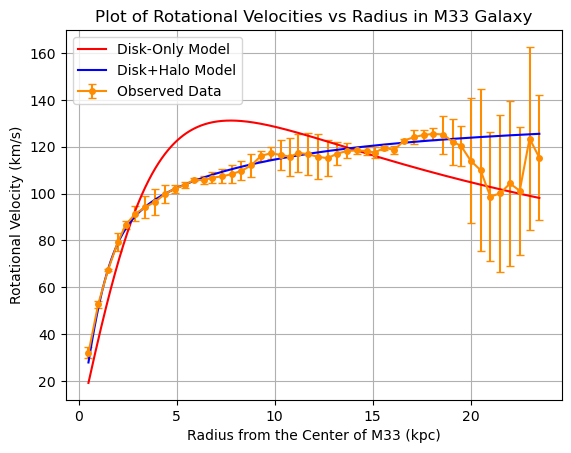

In [5]:
# Plot of the observed data and fitted models
# Plot original values
plt.errorbar(R, V, yerr = sigmaV, marker = 'o', markersize = 4, capsize = 3, color = 'darkorange', label = 'Observed Data')
r_values = np.linspace(min(R), max(R), 1000)

# Disk-only model
V_disk_fit = V_disk(r_values, *pvec_disk)
plt.plot(r_values, V_disk_fit, color = 'red', label = 'Disk-Only Model')

# Disk+halo model
V_both_fit = V_both(r_values, *pvec_both)
plt.plot(r_values, V_both_fit, color = 'blue', label = 'Disk+Halo Model')

plt.title('Plot of Rotational Velocities vs Radius in M33 Galaxy')
plt.xlabel('Radius from the Center of M33 (kpc)')
plt.ylabel('Rotational Velocity (km/s)')
plt.legend()
plt.grid(True)
plt.savefig('M33Compare.jpg')

### Part E: Weighing M33

Using the fitted disk+halo model, estimate the total halo mass out to a radius of 20kpc, $\mathcal{M}_\mathrm{H}(<20\,\mathrm{kpc})$.
How does this value compare to the fitted disk mass, $M_\mathrm{D}$?

In [6]:
# Compute and compare the 20kpc halo and disk masses, in the fitted disk+halo model
# We can extract the disk mass in the disk+halo model from pvec_both. The disk mass is the first entry in the pvec_both
M_disk = pvec_both[0]

# To find the halo mass, we can use the equation from part A.
G      = 4.30e3 # Gravitational constant in $\mathrm{kpc}\cdot{}(\mathrm{km/s})^2 / \mathrm{GM}_\odot$
R      = 20     # Radius from the center of M33 in kpc
M_halo = R * ((V_both(R, *pvec_both))**2) / G

print('Using the fitted disk+halo model, the halo mass out to a radius of 20 kpc is', round(M_halo), 'giga solar masses')
print('Using the fitted disk+halo model, the disk mass out to a radius of 20 kpc is', round(M_disk), 'giga solar masses')
print('Comparing these two values, we conclude that the halo mass is ten times the mass of the disk')

Using the fitted disk+halo model, the halo mass out to a radius of 20 kpc is 71 giga solar masses
Using the fitted disk+halo model, the disk mass out to a radius of 20 kpc is 7 giga solar masses
Comparing these two values, we conclude that the halo mass is ten times the mass of the disk
